<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EC%9C%A0%EC%98%88%EC%8A%AC_%EB%82%A8%EC%83%81%EC%9A%B0_%EC%9E%84%EC%8B%9C%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -U sentence-transformers

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import torch
import torch.nn as nn
from torch import optim
from torch import optim

import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스 자료/Machine Learning/data/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 데이터 불러오기

In [57]:
pd.read_csv(f"{DATA_PATH}train_ft_38000_0918.csv").head(3)

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"['맛있', '먹', '묵사발', '시원', '맛있']",['맛']
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"['양', '푸짐', '맛있', '청국장', '냄새', '나', '콩', '들', ...","['양', '맛']"
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"['냉면', '시키', '미니', '냉면', '합치', '양', '적', '보이',...",['양']


In [12]:
pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv").head(3)

,review,reply,sentiment
0,"맛이 별로였어요, 조리 상태도 별로였고 배달 시간도 오래 걸렸네요","안녕하세요~! 맛이 별로였다고 하셨는데, 제 기준에는 싱겁고 딱히 맛있어 보이지 않...",0
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
2,음식의 퀄리티가 낮아서 별로였어요. 맛이 없어서 실망했어요,음식의 퀄리티가 낮아서 실망하셨다니 정말 죄송합니다. 더 맛있는 음식으로 만족스러운...,0


In [111]:
# train = pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv")
train = pd.read_csv(f"{DATA_PATH}train_ft_38000_0918.csv")
train.isnull().sum()

review          0
reply           0
sentiment       0
score           0
kiwi_reviews    0
category        0
dtype: int64

## 하나의 식당 리뷰로 거름

In [112]:
train.shape

(38555, 6)

SyntaxError: ignored

In [113]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0     9115
1    29440
Name: sentiment, dtype: int64

### 단문 데이터 제거
- 데이터 정제 과정에서 무의미해진 데이터는 학습데이터로 사용불가
    - 리뷰 : 공백만 생겼거나, 리뷰 이벤트를 위한 단답형 제거

In [114]:
train[(train['review'].str.len() > 4) & (train['review'].str.len() <= 10)] # 리뷰

,review,reply,sentiment,score,kiwi_reviews,category
7,맛있게잘먹었습니다,고객님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요! 좋은 하루 보내세요~,1,0.565963,"['맛있', '먹']",['맛']
13,맛있게잘먹었어요,고객님께서 맛있다고 말씀 주시니 피로가 싹~ 사라지네요! 주방에서 힘든 일도 있고 ...,1,0.529402,"['맛있', '먹']",['맛']
19,언제나 맛있습니다,소중한 시간에 저희 매장을 다시 이용해주셔서 감사합니다. 이번에도 만족스러우셨던 거...,1,0.641165,['맛있'],['맛']
23,양도 많고 맛있어요,잊지 않으시고 리뷰 남겨주셔서 정말 감사합니다! 맛있는 메뉴들은 매번 양껏 먹어도 ...,1,0.616185,"['양', '많', '맛있']","['양', '맛']"
33,맛있게 잘 먹었어요,고객님도 항상 행복하시길 바라요!,1,0.491652,"['맛있', '먹']",['맛']
...,...,...,...,...,...,...
35619,맛이 별로였어요,죄송합니다. 어떤 부분에서 맛이 별로인지 알려주시면 개선에 도움이 될 것 같습니다.,0,0.918066,['맛'],['맛']
35759,맛이 별로였어요,"죄송해요, 많이 실망하셨군요. 저희 음식이 맛있게 전달되도록 조금 더 노력하겠습니다.",0,0.918066,['맛'],['맛']
36678,맛이 별로였어요,"죄송합니다, 맛에 대해 별점을 받으셨다니 정말 안타깝습니다. 더 맛있는 음식으로 보...",0,0.918066,['맛'],['맛']
36931,맛이 별로였어요.,죄송합니다. 맛이 별로였다니 정말 안타깝네요. 다음에는 더 좋은 맛으로 보답하겠습니다.,0,0.923817,['맛'],['맛']


In [115]:
train[(train['review'].str.len() > 4) & (train['review'].str.len() <= 10)] # 리뷰

,review,reply,sentiment,score,kiwi_reviews,category
7,맛있게잘먹었습니다,고객님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요! 좋은 하루 보내세요~,1,0.565963,"['맛있', '먹']",['맛']
13,맛있게잘먹었어요,고객님께서 맛있다고 말씀 주시니 피로가 싹~ 사라지네요! 주방에서 힘든 일도 있고 ...,1,0.529402,"['맛있', '먹']",['맛']
19,언제나 맛있습니다,소중한 시간에 저희 매장을 다시 이용해주셔서 감사합니다. 이번에도 만족스러우셨던 거...,1,0.641165,['맛있'],['맛']
23,양도 많고 맛있어요,잊지 않으시고 리뷰 남겨주셔서 정말 감사합니다! 맛있는 메뉴들은 매번 양껏 먹어도 ...,1,0.616185,"['양', '많', '맛있']","['양', '맛']"
33,맛있게 잘 먹었어요,고객님도 항상 행복하시길 바라요!,1,0.491652,"['맛있', '먹']",['맛']
...,...,...,...,...,...,...
35619,맛이 별로였어요,죄송합니다. 어떤 부분에서 맛이 별로인지 알려주시면 개선에 도움이 될 것 같습니다.,0,0.918066,['맛'],['맛']
35759,맛이 별로였어요,"죄송해요, 많이 실망하셨군요. 저희 음식이 맛있게 전달되도록 조금 더 노력하겠습니다.",0,0.918066,['맛'],['맛']
36678,맛이 별로였어요,"죄송합니다, 맛에 대해 별점을 받으셨다니 정말 안타깝습니다. 더 맛있는 음식으로 보...",0,0.918066,['맛'],['맛']
36931,맛이 별로였어요.,죄송합니다. 맛이 별로였다니 정말 안타깝네요. 다음에는 더 좋은 맛으로 보답하겠습니다.,0,0.923817,['맛'],['맛']


In [116]:
len(train[train['review'].str.len() <= 10])

3398

In [117]:
train = train[train['review'].str.len() > 10]
train

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"['맛있', '먹', '묵사발', '시원', '맛있']",['맛']
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"['양', '푸짐', '맛있', '청국장', '냄새', '나', '콩', '들', ...","['양', '맛']"
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"['냉면', '시키', '미니', '냉면', '합치', '양', '적', '보이',...",['양']
3,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870,"['맛나', '묵']",['맛']
4,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,"안녕하세요! 주문해 주셔서 진심으로 감사드려요! 이렇게 좋은 리뷰 써 주시니, 메뉴...",1,0.778149,"['맛', '양', '만족', '배달', '보내', '만족']","['양', '맛', '배달']"
...,...,...,...,...,...,...
38550,항상 맛있게 먹었는데 이번에는 음식이 식어서 별로였어요. 아쉬워요,고객님의 의견을 반영하여 다양한 맛과 양을 제공하도록 노력하겠습니다.,0,0.811507,"['맛있', '먹', '이번', '음식', '식']",['맛']
38551,언제나 맛있게 먹었는데 이번에는 음식이 지루하고 별로였어요. 아쉬워요,"닭도리탕의 맛이 매우 좋지 않고, 김치가 물렸다는 점 죄송합니다. 앞으로 더 맛있는...",0,0.827452,"['맛있', '먹', '이번', '음식', '지루하']",['맛']
38552,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769,"['맛', '음식', '촉촉', '식', '먹', '그렇', '다음', '시키', ...",['맛']
38553,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723,"['맛', '없', '배달', '늦', '실망']","['맛', '배달']"


## 긍부정 데이터 비율 선택

In [118]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0     8978
1    26179
Name: sentiment, dtype: int64

In [119]:
train_neg = train[train['sentiment'] == 0]

# 긍정 데이터 중 중복된 답변제거
train_pos = train[train['sentiment'] == 1].drop_duplicates(subset='reply', keep=False)
train_pos['sentiment'].value_counts().sort_index()

1    11510
Name: sentiment, dtype: int64

In [120]:
length = len(train_neg)
length

8978

In [121]:
# 긍정 데이터를 랜덤으로 추출하기 위해 섞기
shuffled_train_pos = train_pos.sample(frac=1, random_state=42)
shuffled_train_neg = train_neg.sample(frac=1, random_state=42)

train_pos = shuffled_train_pos.iloc[:50].reset_index(drop=True)
train_neg = shuffled_train_neg.iloc[:50].reset_index(drop=True)

# 데이터 합치기
train = pd.concat([train_neg, train_pos], ignore_index=True)
train['sentiment'].value_counts().sort_index()

0    50
1    50
Name: sentiment, dtype: int64

In [79]:
# 다시 섞기
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train

,review,reply,sentiment,score,kiwi_reviews,category
0,집주변 샐러드 정착하겠습니다 매일 먹으면 진짜 다이어트 쌉가능 할듯요 먹으면서 친구...,"너무너무 극찬이시고, 친구분들에게까지 홍보를. 감사할따름입니다 정착하실수 있도록 항...",1,0.899112,"['집', '주변', '샐러드', '정착', '먹', '다이어트', '쌉', '가능...","['맛', '서비스']"
1,고기도 많고 김치가 정말 맛있네요 잘먹었습니다,안녕하세요 신자매 김치찜 김치찌개를 찾아주셔서 진심으로 감사합니다 고기도 많고 김치...,1,0.596139,"['고기', '많', '김치', '맛있', '먹']",['맛']
2,처음 시켜먹었는데 양도 많고 맛있었어요! 고기도 너무 맛있었네요 다음엔 팟타이도 한...,첫주문이신데 입에 맞으셔서 다행입니다~ 다음에는 팟타이로 뵙겠습니다 감사합니다~,1,0.564753,"['시키', '먹', '양', '많', '맛있', '고기', '맛있', '다음', ...","['양', '맛']"
3,배달은 딱 적혀있던 시간에 오고 밥은 설 익어서 딱딱해서 버리고 집에있는밥으로 먹었...,"고객님을 만족시키지 못한 것 같아, 죄송스러울 따름이네요. 혹시라도 다음 기회를 주...",0,0.985933,"['배달', '적히', '시간', '오', '밥', '설', '익', '딱딱하', ...",['배달']
4,맛잇게.잘 먹엇습니다 근데 항상 시키던 짜글이랑 달리 수제비가 들어있고 고기가 먹던...,"고객님 취향에 맞게 제육용 슬라이스 , 촌돼지 두툼한 선택 가능하시구요 감자수제비는...",0,0.287744,"['맛', '먹', '시키', '짜', '글', '수제비', '들', '고기', '...",['맛']
...,...,...,...,...,...,...
95,맛있네요 근데 고기가 워낙 두껍다보니 젤 두꺼운건 덜익긴했어요 양이 많아서 그런거 ...,고객님 아마 붉은살을 보고 덜 익었다고 생각하신 것 같아요. 저희가 익은 것 항상 ...,1,0.532245,"['맛있', '고기', '익', '양', '많', '고르', '배', '터지', '먹']","['양', '맛']"
96,양 푸짐하고 때깔과 맛이 미쳤네요. 고기 새우 오리 다 있어서 고루고루 즐길수 잇다...,동시에 조리하다보니 부족한점이 있을수도있는데 맛있게 드셨다니 너무너무 감사합니다,1,0.900838,"['푸짐', '때깔', '맛', '미치', '고기', '새우', '오리', '있',...","['양', '맛']"
97,고기가 너무 느끼하고 기름지고 맛이 별로였어요. 정말 실망스러웠습니다,맛이 좋지 않았다는 점을 들어 정말 죄송합니다. 다음에는 맛있는 음식을 제공할 수 ...,0,0.934252,"['고기', '느끼', '기름지', '맛', '실망']",['맛']
98,삼겹도시락 맛났어요~ 이 가격에 고기듬뿍은 인정~ 근데 서비스가 아니라 추가 메뉴인...,오늘 저희 매장에 발걸음을 해주셔서 영광입니다 메뉴 시키실 때마다 항상 많이 고민하...,1,0.365189,"['겹', '도시락', '맛', '나', '가격', '고기', '인정', '서비스'...","['가격', '맛', '서비스']"


# 1) 유사도 확인

## 유사도 군집화 라벨 불러오기

In [80]:
pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

,label
0,맛이 없어요
1,양이 적어요
2,배달이 느려요
3,맛은 있는데 양이 적어요
4,맛은 있는데 배달이 느려요
5,양은 많은데 맛이 없어요
6,배달은 빠른데 맛이 없어요
7,양은 많은데 배달이 느려요
8,배달은 빠른데 양이 적어요
9,맛있어요


In [81]:
sim_cluster_label = pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

In [82]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(label_text, review_text, alpha=0.9): # cosine 가중치 조절
    label_embedding = bert_model.encode(label_text)
    review_embedding = bert_model.encode(review_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([label_embedding], [review_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    label_tokens = set(label_text.split())
    review_tokens = set(review_text.split())
    jaccard_sim = len(label_tokens.intersection(review_tokens)) / len(label_tokens.union(review_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

In [84]:
result = []
for label in sim_cluster_label['label']:
    for review in train['review']:
        score = evaluate_similarity(label, review)
        if score >= 0.5:
            result.append({'label': label, 'review': review, 'score': score})

result = pd.DataFrame(result)
result

,label,review,score
0,맛이 없어요,보쌈은 별로였어요. 맛이 없고 고기 양도 적어서 실망했어요.,0.501738
1,맛이 없어요,김치찌게 맵지도 않고 참기름 덕분인지 짜고 맛없어요. 고기도 부족해서 실망이에요.,0.575074
2,맛이 없어요,"음식이 맛있지 않았어요. 김치맛도 별로였고, 고기맛도 특별하지 않았어요.",0.558044
3,맛이 없어요,고기는 별로였어요. 애매하게 맛이 없었고 특이한 매력이 없었어요.,0.556093
4,맛이 없어요,맛은있는데 된장이안왔네요,0.515073
...,...,...,...
67,맛있어요,맛도 너무좋고 신선도도 너무 좋아요 자주 이용해야 할꺼 같아요,0.541500
68,맛있어요,양 푸짐하고 때깔과 맛이 미쳤네요. 고기 새우 오리 다 있어서 고루고루 즐길수 잇다...,0.526982
69,맛있어요,냉면도 그렇고 고기도 정말 맛있었어요!,0.585592
70,양이 많아요,양 푸짐하고 때깔과 맛이 미쳤네요. 고기 새우 오리 다 있어서 고루고루 즐길수 잇다...,0.548760


In [85]:
# 엑셀로 확인
with pd.ExcelWriter("result.xlsx", engine='openpyxl') as writer:
    result.to_excel(writer, sheet_name='시트1', index=False)

# 2) 긍부정 지수 변화 추이

In [126]:
shuffled_train_pos

,review,reply,sentiment,score,kiwi_reviews,category
12252,역시나 맛있게 먹었습니다!,반갑습니다~ 최고 별 점 리뷰을 보니 넘 뿌듯합니다~ 저희 1989마라탕 부천점 맛...,1,0.555977,"['맛있', '먹']",['맛']
9270,리뷰이벤트 귀찮아서 요청 안했는데 넘나리 친절하시게도 음료를 넣어주셨더라구여.! 이...,"안녕하세요 맛있게 드셔 주시고, 저희 서비스에 만족해주셔서 부끄럽습니다. 건강을 지...",1,0.898217,"['리뷰', '이벤트', '귀찮', '요청', '하', '친절', '음료', '넣'...",['서비스']
21312,너무 잘 먹었습니다 수박주스 짱맛나요,수박쥬스는 직접 사와 정성스레 손질해서 제조해드려요 ~! 또 한번 찾아주세용 감사드려요,1,0.724990,"['먹', '수박', '주스', '맛나']",['맛']
26445,매번 시켜먹는데 리뷰는 처음 다네요 주변에 있는 감자탕집중에 제일 맛있어요 변치 않...,"감사합니다,항상 맛있는 음식으로 보답드릴께요 시간내서 리뷰작성해 주셔서 너무너무 감...",1,0.890159,"['시키', '먹', '리뷰', '달', '주변', '있', '감자탕', '집중',...",['맛']
27551,배달원분도 너무 친절하시고 음식도 맛있었습니다,잊지 않고 시간 내어 맛있게 드셨다고 남겨주시는 글들을 보며 힘을 얻습니다~! 실망...,1,0.742900,"['배달원', '친절', '음식', '맛있']","['맛', '서비스']"
...,...,...,...,...,...,...
30145,"굿입니다 보장, 배달 다좋았습니다",고객님의 리뷰에 힘이 나고 기분이 좋습니다 오늘 남은 하루도 잘 마무리 하시고 내일...,1,0.745817,"['굿', '보장', '배달', '좋']",['배달']
14222,너무 배불러서 다 못먹었어요 맵기도 적당하구 완전 한국인 입맛을 맞춘 마라탕이었습니...,감사합니다 ~ 맛있게 드셨다는 리뷰는 저희한테 큰 힘이 됩니다 별점 다섯개를 주실수...,1,0.681785,"['배부르', '먹', '적당', '완전', '한국인', '입맛', '맞추', '마...","['양', '맛']"
14797,국물이 진해요 집에서 먹는맛 양도많아서 설명에 써있는대로 둘이서 먹어야 딱 맞네여 ...,안녕하세요 신자매 김치찜 김치찌개를 찾아주셔서 진심으로 감사합니다 구체적인 리뷰 너...,1,0.677440,"['국물', '진하', '집', '먹', '맛', '양', '많', '설명', '쓰...","['양', '맛']"
3602,정말 배부르고 맛있게 잘먹었습니다~,고객님께서 배부르게 드시라고 서비스까지 넉넉히 보내드려요. 브런치 생각나실 때 다시...,1,0.683654,"['배부르', '맛있', '먹']","['양', '맛']"


In [127]:
shuffled_train_neg

,review,reply,sentiment,score,kiwi_reviews,category
36257,서비스가 엉망이에요. 음식도 맛이 없어요,고객님의 소중한 의견을 반영하여 개선해 보도록 하겠습니다.,0,0.909048,"['서비스', '엉망', '음식', '맛', '없']","['맛', '서비스']"
1841,맛나요 오점 드립니다다다다,맛있게 드셔주셔서 감사드립니다 늘 믿고 드실 수 있게 항상 신선한 재료로 정성을 듬...,0,0.829957,"['맛나', '오점', '드리']",['맛']
38024,카레도 별로고 마제소바 너무 별로용 배달도 느리고 감사합니다,고객님의 다음 방문 때는 만족스러운 음식을 제공해드리기 위해 최선을 다하겠습니다. ...,0,0.805398,"['카레', '마제소바', '용', '배달', '느리', '감사']",['배달']
37233,상추가 상했는지 맛이 좀 이상했어요. 다른 샐러드로 주세요.,"안녕하세요, 맛이 좋지 않아 죄송합니다. 음식의 촉촉함을 보장하기 위해 더 노력하겠...",0,0.869637,"['상추', '상하', '맛', '이상', '샐러드', '주']",['맛']
25661,첫주문라 뭐가 무슨 맛인지 몰라 추천 소스로 했는데 제 스타일은 아니였어요 향신료인...,고객님 안녕하세요~ 처음 주문에 만족을 드리지 못한것 같아 정말 안타깝고 죄송합니다...,0,0.681543,"['주문', '라', '맛', '모르', '추천', '소스', '하', '스타일',...",['맛']
...,...,...,...,...,...,...
35306,차갑게 도착해서 실망했습니다. 맛도 그닥이었어요,이해하고 있습니다. 차갑게 도착한 음식과 맛의 부족함으로 인해 실망하셨을 것 같습니...,0,0.927881,"['도착', '실망', '맛']","['맛', '배달']"
34763,맛이 별로였어요. 좀 싱겁고 딱딱해서 먹기가 좀 그랬어요,맛이 별로였다니 싱겁고 딱딱해서 먹기가 그랬다니 안타까워요. 저희는 맛있는 음식을 ...,0,0.933474,"['맛', '딱딱하', '먹', '그렇']",['맛']
34962,음식이 식어서 왔어요. 회가 싱싱하지 않아서 맛이 좋지 않았어요. 당연히 늦게 배달...,음식이 식어서 오셨다니 정말 죄송합니다. 저희가 배송 시간과 신선도에 더 신경을 쓸...,0,0.943574,"['음식', '식', '오', '회', '싱싱', '맛', '좋', '늦', '배달...","['맛', '배달']"
21406,생각보다 매운맛은 아니에요! 맵찔이도 먹을 수 있습니당,저희 타코야키 매운맛은 매콤하고 맛있는 매움이라 누구나 맛있게 즐기실 수 있습니다!...,0,0.414531,"['생각', '맛', '먹', '있']",['맛']


In [128]:
# train = pd.concat([shuffled_train_pos, shuffled_train_neg], ignore_index=True)
# train.shape

(20488, 6)

In [129]:
# mask = (train['review'].str.contains('고기|돼지|국물')) | (train['reply'].str.contains('고기|돼지|국물'))
# train = train[mask]
# train.shape

(1328, 6)

In [136]:
train_pos = shuffled_train_pos.iloc[:500].reset_index(drop=True)
train_neg = shuffled_train_neg.iloc[:500].reset_index(drop=True)

# 데이터 합치기
train_posneg_1000 = pd.concat([train_neg, train_pos], ignore_index=True)


In [137]:
train_posneg_1000 = train_posneg_1000.sample(frac=1)
train_posneg_1000['ID'] = 0
train_posneg_1000['date'] = 0

In [138]:
train_posneg_1000.reset_index(inplace=True)

In [140]:
train_posneg_1000.drop(columns='index',inplace=True)

In [227]:
train_posneg_1000

,review,reply,sentiment,score,kiwi_reviews,category,ID,date
0,맛있게 먹었어요 집에 고기가 있어서 고기 더 넣어서 끓여먹었네요,고객님에게 만족되는 음식으로 항상 보답드리겠습니다!,1,0.479714,"['맛있', '먹', '집', '고기', '있', '고기', '넣', '끓이', '먹']",['맛'],0,0
1,"배달 시간이 너무 오래 걸렸어요. 음식이 식어버렸고, 맛도 별로였어요. 다시는 시키...",타코야끼의 맛이 이상했다고 하니 저희도 매우 실망스럽습니다. 음식을 준비하는 과정에...,0,0.926318,"['배달', '시간', '걸리', '음식', '식', '맛', '시키']","['맛', '배달']",0,0
2,배달이 너무 늦어서 실망스러웠어요,고객님의 음식을 더 신속하게 전달할 수 있는 방법을 찾아보도록 하겠습니다.,0,0.895064,"['배달', '늦', '실망']",['배달'],0,0
3,음식을 받았는데 이미 식어서 따뜻하지 않아요. 맛은 그럭저럭인데 따뜻해야지 더 맛있...,음식이 따뜻하지 않았던 점에 대해 죄송합니다. 다음에는 따뜻한 상태로 제공할 수 있...,0,0.918011,"['음식', '식', '따뜻', '맛', '따뜻하', '맛있', '먹', '있']",['맛'],0,0
4,냉면 쌈밥 다 맛있었어요 근데 밥이 너무 찰기가 없고 푸석푸석 밥이 아쉽네요,아침에 새로한 밥을 보내야 하는데 남아있던 직원들이 먹는 밥을 잘못 보내버렸네요 음...,1,0.358540,"['냉면', '쌈밥', '맛있', '밥', '찰기', '없', '밥']",['맛'],0,0
...,...,...,...,...,...,...,...,...
995,맛도 별로고 음식이 조금 차갑게 와서 별로였어요. 다음에는 다른 음식을 시켜봐야겠어요,고객님께 맛있는 식사를 선사하도록 하겠습니다.,0,0.921826,"['맛', '음식', '오', '다음', '다르', '음식', '시키']",['맛'],0,0
996,맛이 기대한만큼 나오지 않았어요. 더 맛있는 피자의 맛을 찾아봐야겠어요,피자에 기름이 많아서 드시기 힘들었다니 죄송합니다. 다음에는 기름이 적은 메뉴도 제...,0,0.875650,"['맛', '기대', '나오', '맛있', '피자', '맛', '찾']",['맛'],0,0
997,"음식이 너무 싱겁고 맛이 없어서 다른 음식을 시켰어요, 맛을 개선해주셔야 할 것 같아요",고객님께 만족을 드릴 수 있도록 노력하겠습니다.,0,0.925119,"['음식', '맛', '없', '음식', '시키', '맛', '개선', '같']",['맛'],0,0
998,맛이 좋지 않았어요. 다시는 시키지 않을 거 같아요,고객님의 맛에 대한 기대를 충족시키지 못한 것 같아 안타깝네요. 더 나은 서비스를 ...,0,0.939210,"['맛', '좋', '시키', '같']",['맛'],0,0


- 서로 다른 6자의 아이디 랜덤 생성 / 1월 1일~ 9월 30일까지의 데이터 / 고객 구매주기는 하루 ~ 3달까지 다양함

In [228]:
import random
import string
from datetime import datetime, timedelta
import pandas as pd

# 데이터를 저장할 리스트 초기화
data = []

# 시작 날짜와 종료 날짜 설정
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 9, 30)

# 중복 아이디 생성을 위한 아이디 리스트
all_ids = []

# 1000개의 데이터 생성
while len(data) < 1000:
    # 랜덤 문자열 아이디 생성 (예: 6자리 길이)
    customer_id = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

    # 무작위 시작 날짜 생성 (start_date와 end_date 사이)
    start_date_random = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

    # 1일부터 2달에서 3달 사이의 반복 주기 생성
    repeat_period = random.randint(1, 180)

    current_date = start_date_random
    while current_date <= end_date and len(data) < 1000:
        data.append({'ID': customer_id, '날짜': current_date})
        current_date += timedelta(days=repeat_period)

# 데이터프레임 생성
df = pd.DataFrame(data)

# 날짜순으로 데이터프레임 정렬
df.sort_values(by=['날짜'], inplace=True)

# 데이터프레임 출력
df


,ID,날짜
419,KUc1j6,2023-07-01
79,wFYfsm,2023-07-01
650,MZ32hI,2023-07-01
967,1wCQTI,2023-07-01
537,fRGsQI,2023-07-01
...,...,...
729,BsBl8q,2023-09-30
357,c1YML4,2023-09-30
956,hARfdY,2023-09-30
7,OcPtMQ,2023-09-30


In [229]:
df = pd.concat([df,train_posneg_1000[['review','reply','sentiment','score']]], axis=1)
df

,ID,날짜,review,reply,sentiment,score
419,KUc1j6,2023-07-01,맛잇어요 배달빠르고 굳,리뷰 감사드립니다 . .,1,0.648363
79,wFYfsm,2023-07-01,닭발좋아해서 한달에 몇번은시켜먹어요 솔직히 배달료가 비싸서 투덜대지만 먹고싶으니까 ...,정성스러운 리뷰에 감동햇어요~ 이번달 까지 무료배송이벤트 진행중이니 한번더 뵜음 좋...,1,0.908330
650,MZ32hI,2023-07-01,생선카츠가 별로였어요. 맛이 기대만큼 없어서 아쉬웠어요,생선카츠가 맛이 별로였다니 아쉬워요. 기대하신 만큼의 맛이 없어서 정말 죄송합니다.,0,0.906188
967,1wCQTI,2023-07-01,맛있어요~ 자주시켜먹을게요~,잭아저씨 족발보쌈을 찾아주셔서 감사합니다 맛있게 드셔주셔서 감사해요! 기분 좋은 식...,1,0.663849
537,fRGsQI,2023-07-01,배고파서 빨리 먹느라 사진을 못 찍었어요 항상 볶음을 먹는데 볶음도 맛있지만 구이가...,반갑습니다. 오늘도 저희 땡초를 찾아주시고 소중한 리뷰를 남겨주셔서 감사합니다. 막...,1,0.390519
...,...,...,...,...,...,...
729,BsBl8q,2023-09-30,맛이 싱겁고 배달이 늦어서 실망했어요.,맛이 싱겁고 배달이 늦어서 실망하셨다니 정말 죄송합니다. 맛과 배달 시간을 개선하기...,0,0.924258
357,c1YML4,2023-09-30,"맛이 별로였어요. 너무 짰고, 싱거웠습니다.",맛이 싱거웠다니 정말 죄송합니다. 다음에는 더 맛있는 음식을 제공해드릴 수 있도록 ...,0,0.923708
956,hARfdY,2023-09-30,양이 많아서 너무 좋아요 맛있게 잘먹었습니다.,감사합니다! 각 1인분 셋팅이지만 1.5분인분 느낌으로 양을 정했습니다,1,0.585689
7,OcPtMQ,2023-09-30,오랜만에 먹는데 항상 맛있게 먹던 그 맛이네요. 맛있게 잘먹었습니다.,고객님 안녕하세요. 가끔씩 생각나실 때 주문 주시더라도 항상 예전 맛 그대로 유지하...,1,0.566210


In [230]:
mask = df['sentiment'] == 0
df_neg = df[mask]

In [231]:
mask = df['sentiment'] == 1
df_pos = df[mask]

df_neg.shape, df_pos.shape

((500, 6), (500, 6))

- 일자별 긍정 지수

In [232]:
pos_daily_sentiment = df_pos.groupby('날짜')['score'].sum().reset_index()
pos_daily_sentiment.columns = ['date','pos_daily_score']


- 일자별 부정 지수

In [233]:
neg_daily_sentiment = df_neg.groupby('날짜')['score'].sum().reset_index()
neg_daily_sentiment.columns = ['date','neg_daily_score']

In [234]:
merged_df = pd.merge(pos_daily_sentiment, neg_daily_sentiment, on='date')
merged_df

,date,pos_daily_score,neg_daily_score
0,2023-07-01,5.088414,2.761802
1,2023-07-02,2.816291,1.864699
2,2023-07-03,0.571981,4.624270
3,2023-07-04,2.184027,3.662859
4,2023-07-05,3.480821,1.885538
...,...,...,...
83,2023-09-26,5.458271,4.980109
84,2023-09-27,5.674885,11.609153
85,2023-09-28,4.133008,9.209770
86,2023-09-29,4.727492,5.719432


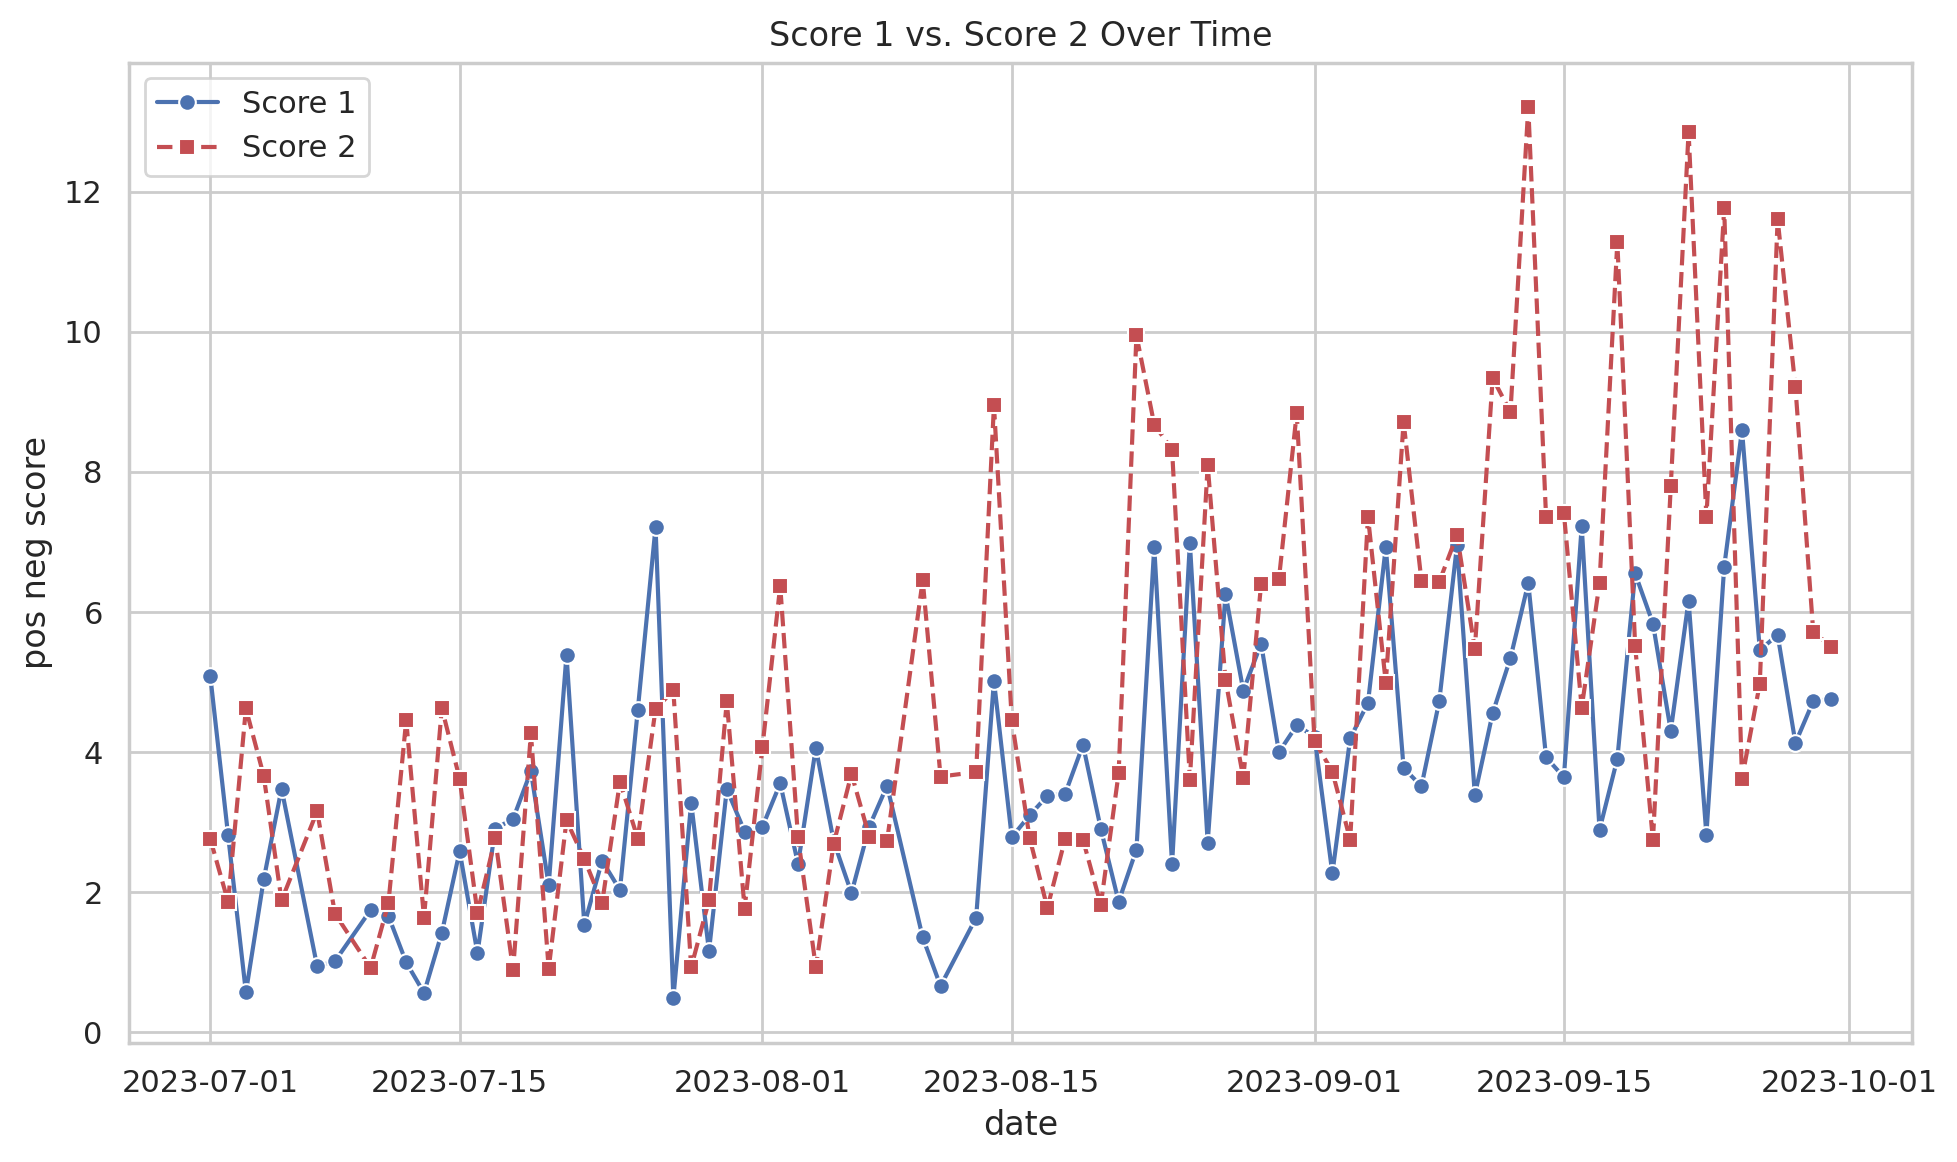

In [235]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)

# 날짜를 Datetime 형식으로 변환
# merged_df['date'] = pd.to_datetime(merged_df['date'])

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# score 1 그래프 그리기
sns.lineplot(data=merged_df, x='date', y='pos_daily_score', label='Score 1', marker='o', linestyle='-', color='b')

# score 2 그래프 그리기
sns.lineplot(data=merged_df, x='date', y='neg_daily_score', label='Score 2', marker='s', linestyle='--', color='r')

# 그래프 제목과 레이블 설정
plt.title('Score 1 vs. Score 2 Over Time')
plt.xlabel('date')
plt.ylabel('pos neg score')

# 범례 추가
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


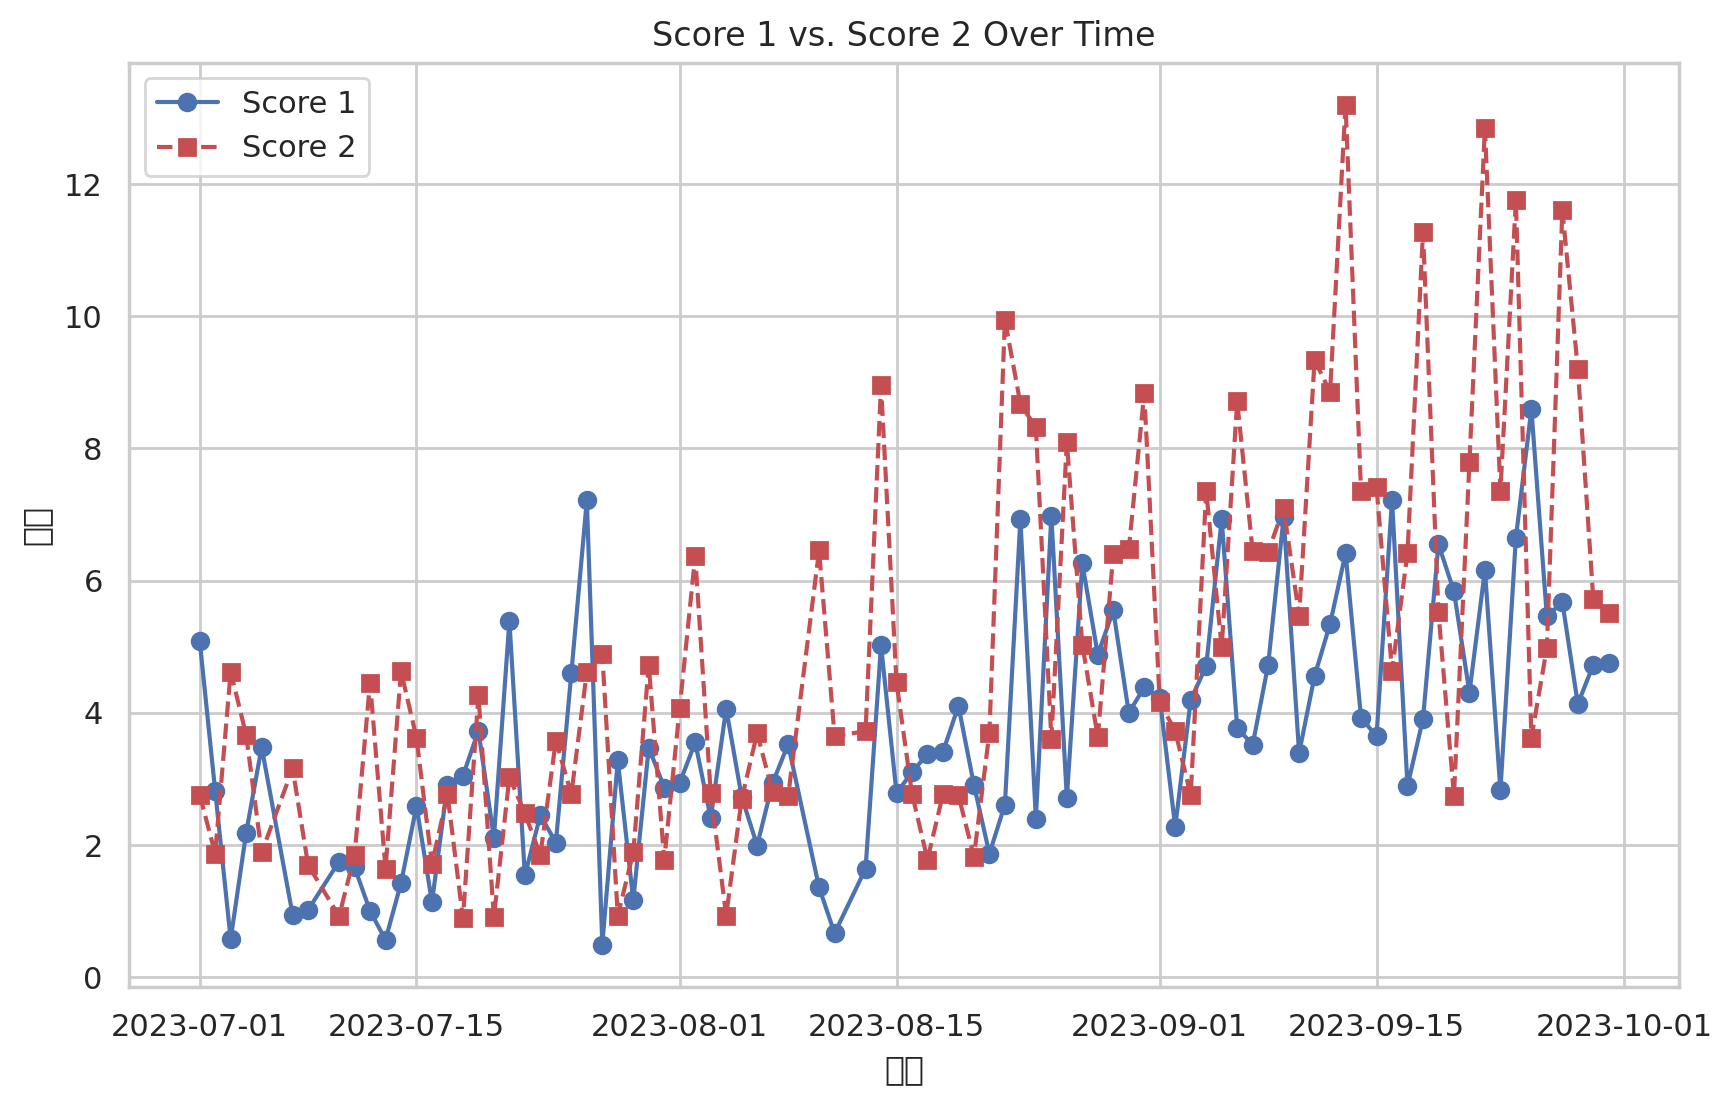

In [236]:
# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# score 1 그래프 그리기
plt.plot(merged_df['date'], merged_df['pos_daily_score'], label='Score 1', marker='o', linestyle='-', color='b')

# score 2 그래프 그리기
plt.plot(merged_df['date'], merged_df['neg_daily_score'], label='Score 2', marker='s', linestyle='--', color='r')

# 그래프 제목과 레이블 설정
plt.title('Score 1 vs. Score 2 Over Time')
plt.xlabel('날짜')
plt.ylabel('점수')
plt.legend()  # 범례 추가


# 3) 부정지수 토픽별 분포도

In [239]:
#대충 이 부분을 어떻게 설명하면 좋을 지

,ID,날짜
0,SJho1Q,2023-08-02
1,OcPtMQ,2023-08-13
2,OcPtMQ,2023-08-21
3,OcPtMQ,2023-08-29
4,OcPtMQ,2023-09-06
...,...,...
995,k1orjz,2023-07-14
996,k1orjz,2023-07-31
997,k1orjz,2023-08-17
998,k1orjz,2023-09-03


# 4) 고객별 온도 확인 (리뷰 빈도 / 긍부정 / 토픽)

In [238]:
df

,ID,날짜
0,SJho1Q,2023-08-02
1,OcPtMQ,2023-08-13
2,OcPtMQ,2023-08-21
3,OcPtMQ,2023-08-29
4,OcPtMQ,2023-09-06
...,...,...
995,k1orjz,2023-07-14
996,k1orjz,2023-07-31
997,k1orjz,2023-08-17
998,k1orjz,2023-09-03
